In [15]:
import numpy as np
from keras.optimizers import SGD
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.nn import local_response_normalization
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [16]:
def tf_example(input_shape, num_classes):
    """CNN Model from TensorFlow v1.x example.

    This is the model referenced on the FedAvg paper.

    Reference:
    https://web.archive.org/web/20170807002954/https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py
    """
    input_shape = tuple(input_shape)

    weight_decay = 0.004
    model = keras.Sequential(
        [
            keras.layers.Conv2D(
                64,
                (5, 5),
                padding="same",
                activation="relu",
                input_shape=input_shape,
            ),
            keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same"),
            keras.layers.Lambda(
                local_response_normalization,
                arguments={
                    "depth_radius": 4,
                    "bias": 1.0,
                    "alpha": 0.001 / 9.0,
                    "beta": 0.75,
                },
            ),
            keras.layers.Conv2D(
                64,
                (5, 5),
                padding="same",
                activation="relu",
            ),
            keras.layers.Lambda(
                local_response_normalization,
                arguments={
                    "depth_radius": 4,
                    "bias": 1.0,
                    "alpha": 0.001 / 9.0,
                    "beta": 0.75,
                },
            ),
            keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same"),
            keras.layers.Flatten(),
            keras.layers.Dense(
                384, activation="relu", kernel_regularizer=l2(weight_decay)
            ),
            keras.layers.Dense(
                192, activation="relu", kernel_regularizer=l2(weight_decay)
            ),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    optimizer = SGD(learning_rate=0.1)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    return model



In [17]:
def cifar10(num_classes, input_shape):
    """Prepare the CIFAR-10.

    This method considers CIFAR-10 for creating both train and test sets. The sets are
    already normalized.
    """
    print(f">>> [Dataset] Loading CIFAR-10. {num_classes} | {input_shape}.")
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    input_shape = x_train.shape[1:]
    num_classes = len(np.unique(y_train))

    return x_train, y_train, x_test, y_test, input_shape, num_classes

In [18]:
x_train, y_train, x_test, y_test, input_shape,num_classes = cifar10(10, (32,32,3))


>>> [Dataset] Loading CIFAR-10. 10 | (32, 32, 3).


In [19]:
EPOCHS=350
BATCH_SIZE=128

---

In [20]:
model = tf_example(input_shape, num_classes)

In [21]:
history = model.fit(x_train, to_categorical(y_train, num_classes), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/350
391/391 [==============================] - 8s 18ms/step - loss: 4.8242 - accuracy: 0.2914
Epoch 2/350
391/391 [==============================] - 7s 18ms/step - loss: 3.0276 - accuracy: 0.4814
Epoch 3/350
391/391 [==============================] - 7s 18ms/step - loss: 2.1395 - accuracy: 0.5609
Epoch 4/350
391/391 [==============================] - 7s 18ms/step - loss: 1.6463 - accuracy: 0.6129
Epoch 5/350
391/391 [==============================] - 7s 18ms/step - loss: 1.3656 - accuracy: 0.6504
Epoch 6/350
391/391 [==============================] - 7s 18ms/step - loss: 1.1851 - accuracy: 0.6868
Epoch 7/350
391/391 [==============================] - 7s 18ms/step - loss: 1.0698 - accuracy: 0.7147
Epoch 8/350
391/391 [==============================] - 7s 18ms/step - loss: 0.9918 - accuracy: 0.7350
Epoch 9/350
391/391 [==============================] - 7s 18ms/step - loss: 0.9465 - accuracy: 0.7551
Epoch 10/350
391/391 [==============================] - 7s 18ms/step - loss: 0.899

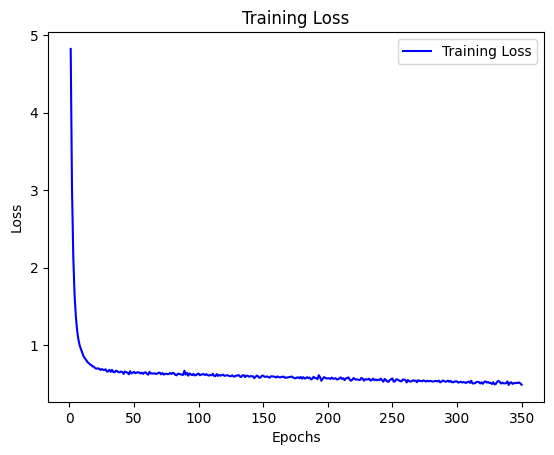

In [22]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
model.evaluate(x_test, to_categorical(y_test, num_classes))

313/313 [==============================] - 1s 3ms/step - loss: 1.5913 - accuracy: 0.7413


[1.5913232564926147, 0.7412999868392944]

---

In [24]:
def cnn(input_shape, num_classes):
    """CNN Model from (McMahan et. al., 2017).

    Communication-efficient learning of deep networks from decentralized data
    """
    input_shape = tuple(input_shape)

    weight_decay = 0.004
    model = keras.Sequential(
        [
            keras.layers.Conv2D(
                64,
                (5, 5),
                padding="same",
                activation="relu",
                input_shape=input_shape,
            ),
            keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                64,
                (5, 5),
                padding="same",
                activation="relu",
            ),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(
                384, activation="relu", kernel_regularizer=l2(weight_decay)
            ),
            keras.layers.Dense(
                192, activation="relu", kernel_regularizer=l2(weight_decay)
            ),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    optimizer = SGD(learning_rate=0.1)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    return model

In [25]:
model_cnn = cnn(input_shape, num_classes)

In [26]:
history_cnn = model_cnn.fit(x_train, to_categorical(y_train, num_classes), epochs=350, batch_size=100)

Epoch 1/350
500/500 [==============================] - 4s 7ms/step - loss: 4.1634 - accuracy: 0.4622
Epoch 2/350
500/500 [==============================] - 3s 7ms/step - loss: 2.3282 - accuracy: 0.6234
Epoch 3/350
500/500 [==============================] - 3s 7ms/step - loss: 1.5241 - accuracy: 0.6978
Epoch 4/350
500/500 [==============================] - 3s 7ms/step - loss: 1.1409 - accuracy: 0.7442
Epoch 5/350
500/500 [==============================] - 3s 7ms/step - loss: 0.9513 - accuracy: 0.7783
Epoch 6/350
500/500 [==============================] - 3s 7ms/step - loss: 0.8526 - accuracy: 0.8004
Epoch 7/350
500/500 [==============================] - 3s 7ms/step - loss: 0.7955 - accuracy: 0.8228
Epoch 8/350
500/500 [==============================] - 3s 7ms/step - loss: 0.7653 - accuracy: 0.8402
Epoch 9/350
500/500 [==============================] - 3s 7ms/step - loss: 0.7479 - accuracy: 0.8540
Epoch 10/350
500/500 [==============================] - 3s 7ms/step - loss: 0.7359 - accura

In [27]:
model_cnn.evaluate(x_test, to_categorical(y_test, num_classes))

313/313 [==============================] - 1s 2ms/step - loss: 1.4919 - accuracy: 0.7581


[1.491928219795227, 0.7580999732017517]

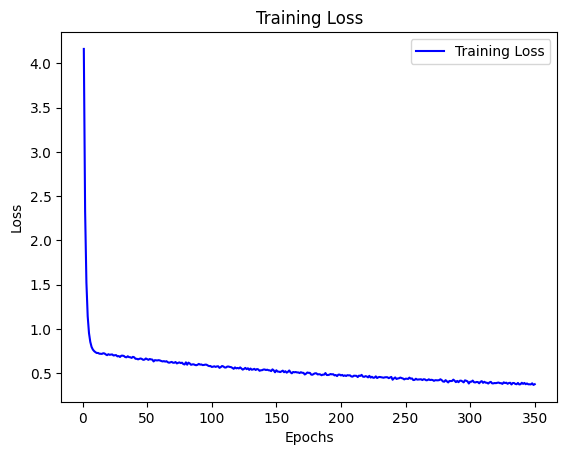

In [28]:
loss = history_cnn.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
